In [1390]:
from src.tree_sitter_AST_utils import Tree_Sitter_ENFA, sub_str_from_coords, Node_Processor, Code_Parser, StringTSNode, get_grammar_vocab, regex_to_member
import json
import networkx as nx
from IPython.display import Image, display
import autopep8
from collections.abc import Iterable
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1391]:
with open("src/tree-sitter/tree-sitter-python/src/grammar.json", "r") as grammar_file:
    python_grammar = json.load(grammar_file)

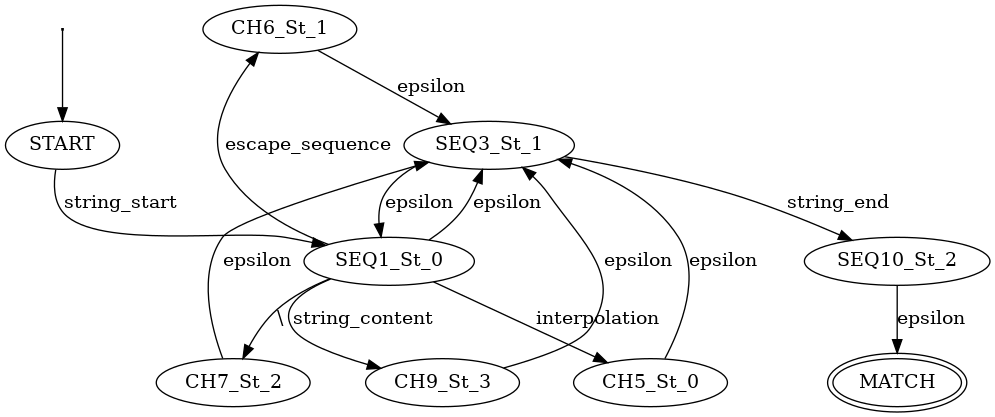

In [1158]:
node_NFA = Tree_Sitter_ENFA("string", python_grammar)
node_NFA.plot_dot()

In [1159]:
node_NFA.validate_sequence([".","4","4","l"])

set()

In [1160]:
possible_transitions = set()
for transitions in list(node_NFA._transition_function._transitions.values()):
    for t,v in transitions.items():
        possible_transitions.update([t])
        
print(possible_transitions)
possible_transitions.remove("epsilon")
all(["regex" in t for t in possible_transitions])

{epsilon, string_start, string_content, escape_sequence, string_end, interpolation, \}


KeyError: 'epsilon'

## Pretty Printing a tree sitter parse tree

In [1372]:
code_str = """
{'a"':56.6666}
4 = 6
"""

In [1373]:
python_parser = Code_Parser("python")
node_processor = Node_Processor()

In [1374]:
code_tree = python_parser.parse_to_string_tree(code_str)

In [1375]:
print(autopep8.fix_code(node_processor.to_string(code_tree)))

{"a"": 56.6666}
4 = 6



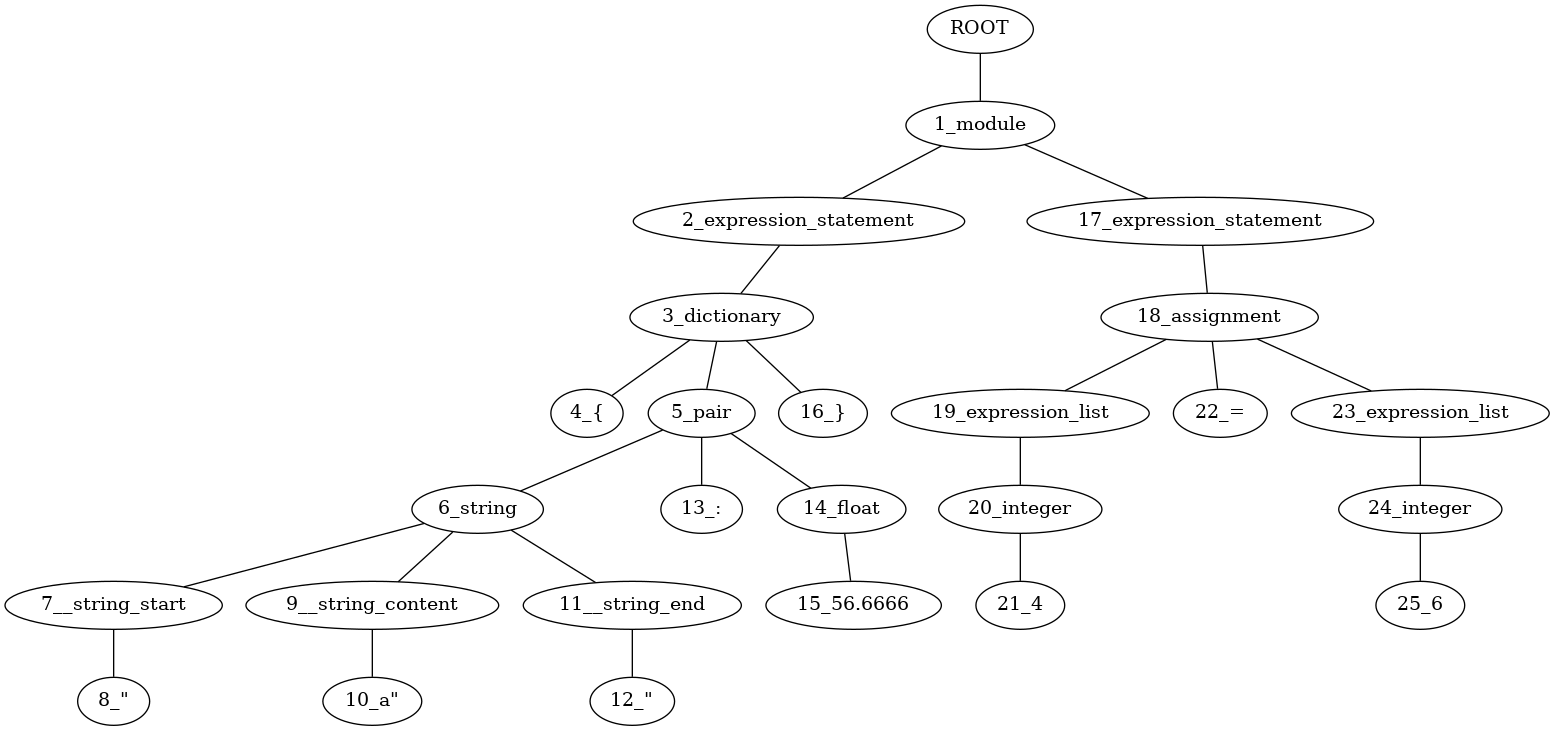

In [1376]:
node_processor.plot(code_tree)

### Getting the grammar vocabulary

In [1171]:
code_tree.children[0].children[0].children[1].children[0].children

In [1172]:
vocab, grammar_patterns = get_grammar_vocab(python_grammar)

In [1173]:
for tree_node in vocab:
    if tree_node not in python_grammar["rules"]:
        print([tree_node])

['True']
['/=']
['^']
['return']
['while']
['try']
['<<=']
['assert']
['pass']
['as']
[':=']
['==']
['&']
['print']
['**']
['global']
['finally']
['**=']
['with']
['0B']
['^=']
['{']
[',']
['for']
['.']
['break']
['None']
['elif']
['*']
['|=']
['0x']
[';']
['%=']
['in']
['0o']
['<>']
['|']
['>=']
['+=']
[']']
['_newline']
['0O']
['_dedent']
[':']
['<']
['0X']
['raise']
['[']
['=']
['-=']
['nonlocal']
['else']
['False']
['class']
['async']
['is']
['//=']
['*=']
['//']
['not']
['and']
['string_start']
['def']
['exec']
['(']
['->']
['except']
['>>']
['>>=']
['~']
['_indent']
['__future__']
['...']
['<<']
['+']
['#']
['from']
['continue']
['import']
['string_content']
['or']
['%']
['<=']
['-']
['/']
['>']
['if']
['@']
['del']
['0b']
['&=']
[')']
['}']
['string_end']
['@=']
['!=']
['\\']


In [1174]:
import re
pattern = re.compile(r"[[0-9]+_?")
pattern.match(r"66_5")

<_sre.SRE_Match object; span=(0, 3), match='66_'>

In [1248]:
class PartialNode():
    def __init__(self, parent, node_type, ENFA, node_builder, is_textual, text=""):
        self.parent = parent
        self.type = node_type
        self.ENFA = ENFA
        self.children = []
        self.text = text
        self.is_textual = is_textual
        self.node_builder = node_builder
    
        
    @property
    def is_complete(self):
        child_sequence = [child.type for child in self.children]
        children_expansions = self.ENFA.validate_sequence(child_sequence)
        text_expansions = self.ENFA.validate_sequence(list(self.text))
        children_complete = "<REDUCE>" in children_expansions
        text_complete = "<REDUCE>" in text_expansions
        return children_complete or text_complete
    
    @property
    def explicit_expansions(self):
        # make a check for the is_textual property since the requirements are different for it.
        if self.is_textual:
            char_sequence = list(self.text)
            expansions = self.ENFA.validate_sequence(char_sequence)
            return expansions
        else:
            child_sequence = [child.type for child in self.children]
            expansions = self.ENFA.validate_sequence(child_sequence)
            return expansions
    
    def is_valid_pattern_expansion(self, expansion_token):
        if self.is_textual and expansion_token != "<REDUCE>":                
            char_sequence = list(self.text+expansion_token)
            expansions = self.ENFA.validate_sequence(char_sequence)
            if expansions != set():
                return True
            return False
        else:
            if expansion_token in self.explicit_expansions:
                return True
            return False
    
    def expansions_mask(self, expansion_vocab):
        return [self.is_valid_pattern_expansion(token) for token in expansion_vocab]
    
    def add_expansion(self, expansion_token):
        is_valid = self.is_valid_pattern_expansion(expansion_token)
        assert is_valid, f"{expansion_token} is not currently a valid expansion for {self.type}. "+\
                                                            f"possible explicit ones: {self.explicit_expansions}"
        if self.is_textual:
            self.text += expansion_token
#             self.children.append(transition_pattern)
            return self
        else:
            new_child = node_builder.create(self, expansion_token)
            self.children.append(new_child)
            return new_child

In [1249]:
class NodeBuilder():
    def __init__(self, grammar):
        self.grammar = grammar
        rule_node_types = grammar["rules"].keys()
        self.node_ENFAs = {node_type: Tree_Sitter_ENFA(node_type, self.grammar) for node_type in rule_node_types}
        self.vocab, self.grammar_paterns = get_grammar_vocab(grammar)
        
        for node_type in self.vocab:
            if node_type not in self.node_ENFAs:
                self.node_ENFAs[node_type] = Tree_Sitter_ENFA(None, self.grammar)   
    @staticmethod            
    def member_has_pattern(member):
        if member == None:
            return False
        elif member["type"] == "PATTERN":
            return True
        elif member["type"] in ["SEQ", "CHOICE"]:
            return any([NodeBuilder.member_has_pattern(sub_member) for sub_member in member["members"]])
        elif member["type"] in ["FIELD", "PREC","PREC_LEFT","PREC_RIGHT","ALIAS", "TOKEN", "REPEAT", "REPEAT1"]:
            return NodeBuilder.member_has_pattern(member["content"])
        
        return False
    
    def create(self, parent, node_type, text=""):
        is_textual = self.member_has_pattern(self.grammar["rules"].get(node_type))
        return PartialNode(parent, node_type, self.node_ENFAs[node_type], self, is_textual, text)

In [1392]:
class PartialTree():
    def __init__(self,seq, node_builder):
        self.full_seq = seq[:1]
        self.node_builder = node_builder
        self.root = node_builder.create(None, seq[0])
        self.pointer = self.root
        seq = seq[1:]
        for node_type in seq:
            self.add_action(node_type)
        
    def add_action(self,expansion_token):
        is_valid = self.pointer.is_valid_pattern_expansion(expansion_token)
        assert is_valid, f"{expansion_token} is not currently a valid expansion for {self.pointer.type}. "+\
                                                            f"possible explicit ones: {self.pointer.explicit_expansions}"
        
        if expansion_token == "<REDUCE>" and self.pointer.parent == None:
            print("Tree generation terminated")
            return None
    
        if expansion_token == "<REDUCE>":
            self.pointer = self.pointer.parent
        else:
            new_child = self.pointer.add_expansion(expansion_token)
            self.pointer = new_child
        self.full_seq.append(expansion_token)

        return self.pointer
    
    @property
    def pointer_explicit_expansions(self):
        self.pointer.explicit_expansions
    

In [1393]:
seq = ['module', 'expression_statement']
extra_externals = {"_string_start":{
                      "type": "PATTERN",
                      "value": '"'
                    },
                   "_string_content":{
                      "type": "PATTERN",
                      "value": "[A-Za-z0-9 _,.()\/{}!$@'*]*"
                    },
                   "_string_end":{
                      "type": "PATTERN",
                      "value": '"'
                    },
                   "_newline":{
                      "type": "BLANK"
                    }
                  }
for node_type, member in extra_externals.items():
    python_grammar["rules"][node_type] = member
    external_to_remove = {"type": "SYMBOL", "name": node_type}
    
node_builder = NodeBuilder(python_grammar)
partial_tree = PartialTree(seq, node_builder)

In [1394]:
partial_tree.add_action('assignment')
partial_tree.add_action("expression_list")
partial_tree.add_action("identifier")
partial_tree.add_action("foo_")
partial_tree.add_action("foo")
partial_tree.add_action("<REDUCE>")
partial_tree.add_action("<REDUCE>")
partial_tree.add_action("=")
partial_tree.add_action("<REDUCE>")
partial_tree.add_action("expression_list")
partial_tree.add_action("string")
partial_tree.add_action('_string_start')
partial_tree.add_action('"')
partial_tree.add_action("<REDUCE>")
partial_tree.add_action("_string_content")
partial_tree.add_action("hello world!")
partial_tree.add_action("<REDUCE>")
partial_tree.add_action("_string_end")
partial_tree.add_action('"')
partial_tree.add_action("<REDUCE>")
partial_tree.add_action("<REDUCE>")
partial_tree.add_action("<REDUCE>")
partial_tree.add_action("<REDUCE>")

In [1363]:
node_processor = Node_Processor()
print(autopep8.fix_code(node_processor.to_string(partial_tree.root)))

foo_foo = "hello world!"
_newline



In [1366]:
partial_tree.pointer.expansions_mask(['"'])

[False]

In [1361]:
partial_tree.add_action("_newline")

In [1313]:
partial_tree.add_action('_string_content')

In [1245]:
partial_tree.full_seq

['module',
 'expression_statement',
 'assignment',
 'expression_list',
 'identifier',
 'foo_',
 'foo']

In [1395]:
partial_tree.pointer.explicit_expansions

{'<REDUCE>'}

In [1345]:
partial_tree.pointer.text

''

In [1327]:
partial_tree.pointer.is_valid_pattern_expansion("hello ")

False

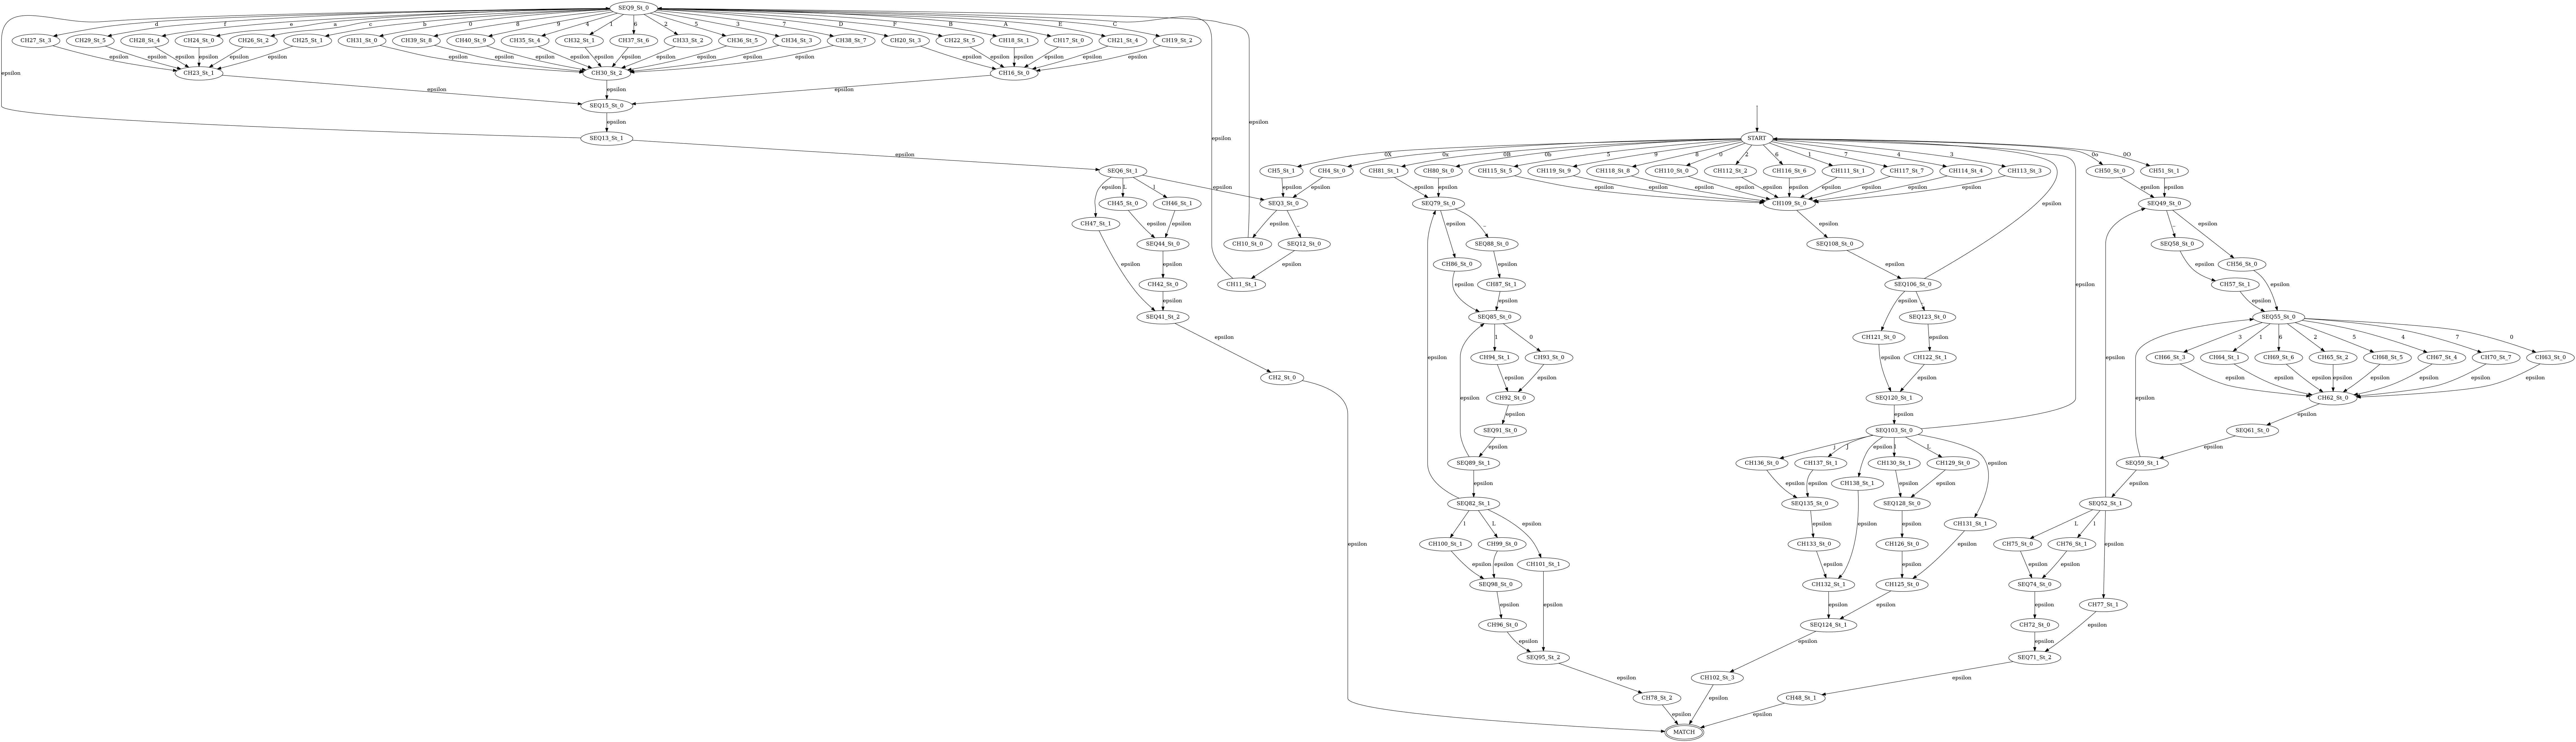

In [1014]:
partial_tree.pointer.ENFA.plot_dot()

In [1388]:
partial_tree.add_action("<REDUCE>")

In [906]:
NodeBuilder.member_has_pattern(python_grammar["rules"].get("integer"))

{'type': 'TOKEN', 'content': {'type': 'CHOICE', 'members': [{'type': 'SEQ', 'members': [{'type': 'CHOICE', 'members': [{'type': 'STRING', 'value': '0x'}, {'type': 'STRING', 'value': '0X'}]}, {'type': 'REPEAT1', 'content': {'type': 'PATTERN', 'value': '_?[A-Fa-f0-9]+'}}, {'type': 'CHOICE', 'members': [{'type': 'PATTERN', 'value': '[Ll]'}, {'type': 'BLANK'}]}]}, {'type': 'SEQ', 'members': [{'type': 'CHOICE', 'members': [{'type': 'STRING', 'value': '0o'}, {'type': 'STRING', 'value': '0O'}]}, {'type': 'REPEAT1', 'content': {'type': 'PATTERN', 'value': '_?[0-7]+'}}, {'type': 'CHOICE', 'members': [{'type': 'PATTERN', 'value': '[Ll]'}, {'type': 'BLANK'}]}]}, {'type': 'SEQ', 'members': [{'type': 'CHOICE', 'members': [{'type': 'STRING', 'value': '0b'}, {'type': 'STRING', 'value': '0B'}]}, {'type': 'REPEAT1', 'content': {'type': 'PATTERN', 'value': '_?[0-1]+'}}, {'type': 'CHOICE', 'members': [{'type': 'PATTERN', 'value': '[Ll]'}, {'type': 'BLANK'}]}]}, {'type': 'SEQ', 'members': [{'type': 'REPEA

False

In [1387]:
partial_tree.pointer.type

'expression_statement'

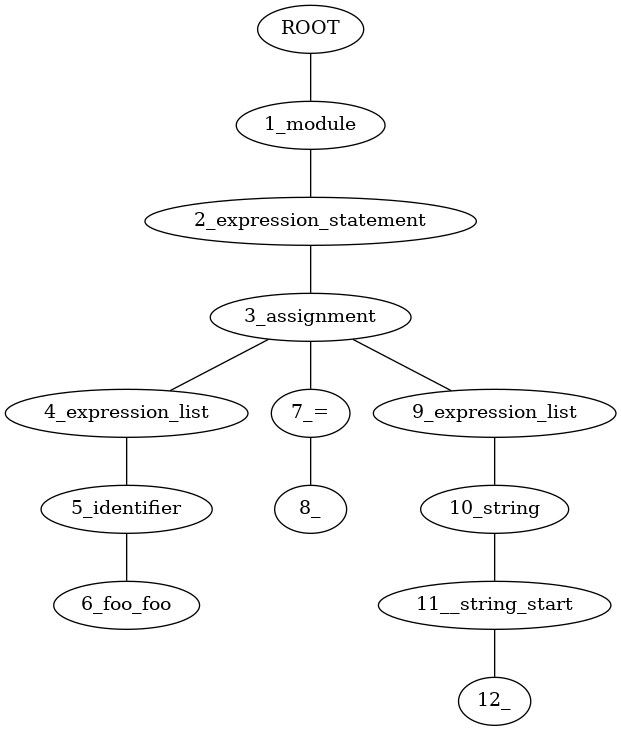

In [1068]:
node_processor.plot(partial_tree.root)

In [94]:
print(partial_tree.pointer.type, partial_tree.pointer.child_expansions, partial_tree.pointer.is_complete)

identifier {'regex:[a-zA-Zα-ωΑ-Ω_][a-zA-Zα-ωΑ-Ω_0-9]*'} True


In [611]:
set_ to f 3 and <REDUCE>

> <ipython-input-599-485b6598ba19>(26)is_valid_pattern_expansion()
     24                 concated = self.text+action
     25                 if re.search(expansion[6:], concated) == None:
---> 26                     raise Exception("String doesn't match the regex, stay calm, you got this carlos")
     27                 idx_start, idx_end = re.search(expansion[6:], concated).regs[0]
     28                 if idx_end == len(concated):



ipdb>  expansion


'regex:[0-9]+_?'


ipdb>  concated


''


ipdb>  re.search(expansion[6:], concated)
ipdb>  exit


In [608]:
partial_tree.add_action("integer")

In [597]:
seq = ["float",'.','R']
node_builder = NodeBuilder(python_grammar)
partial_tree = PartialTree(seq, node_builder)

In [598]:
print(partial_tree.pointer.type, partial_tree.pointer.child_expansions, partial_tree.pointer.is_complete)

float {'regex:[0-9]+_?'} False


In [548]:
import re
re.search(r'', '')

<_sre.SRE_Match object; span=(0, 0), match=''>

In [400]:
'regex:[a-zA-Zα-ωΑ-Ω_][a-zA-Zα-ωΑ-Ω_0-9]*'[:6]

'regex:'

In [39]:
from pyformlang.regular_expression import Regex
from pyformlang.finite_automaton import EpsilonNFA, State, Symbol, Epsilon

In [32]:
class CustomRegex(Regex):
    def to_epsilon_nfa(self):
        """ Transforms the regular expression into an epsilon NFA
        Returns
        ----------
        enfa : :class:`~pyformlang.finite_automaton.EpsilonNFA`
            An epsilon NFA equivalent to the regex
        """
        self._initialize_enfa()
        s_initial = self._set_and_get_initial_state_in_enfa()
        s_final = self._set_and_get_final_state_in_enfa()
        self._process_to_enfa(s_initial, s_final)
        return self._enfa

In [30]:
node_NFA = Tree_Sitter_ENFA("dictionary", python_grammar)

In [461]:
regex = Regex("(a-|a a b)*")
enfa2 = regex.to_epsilon_nfa()

33.4

33 . 4

In [462]:
enfa2.__class__ = Tree_Sitter_ENFA

In [463]:
enfa2.start_state = State(0)
enfa2.validate_sequence(["ff"])

set()

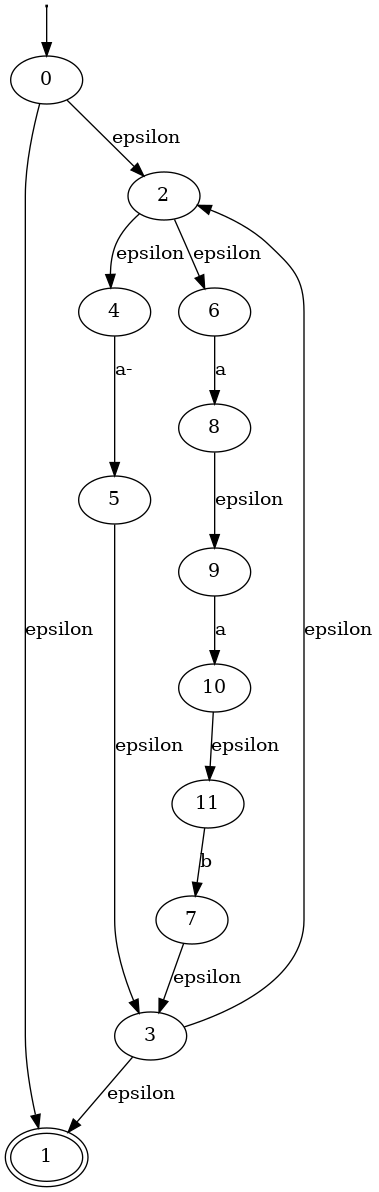

In [465]:
graph = enfa2.to_networkx()

pdot = nx.drawing.nx_pydot.to_pydot(graph)
png_str = pdot.write_png("/tmp/graph.png")
display(Image(filename='/tmp/graph.png'))

In [1087]:
import sre_parse
# print(dir(sre_parse.parse(r'[a-zA-Zα-ωΑ-Ω_][a-zA-Zα-ωΑ-Ω_0-9]*')))
sre_parse.parse('([^"]|\\")*')

[(MAX_REPEAT, (0, MAXREPEAT, [(SUBPATTERN, (1, 0, 0, [(BRANCH, (None, [[(NOT_LITERAL, 34)], [(LITERAL, 34)]]))]))]))]

In [1089]:
memb = regex_to_member("[A-Za-z0-9 _,.()\/{}$@'*]*")
memb

{'type': 'SEQ',
 'members': [{'type': 'REPEAT',
   'content': {'type': 'SEQ',
    'members': [{'type': 'CHOICE',
      'members': [{'type': 'CHOICE',
        'members': [{'type': 'STRING', 'value': 'A'},
         {'type': 'STRING', 'value': 'B'},
         {'type': 'STRING', 'value': 'C'},
         {'type': 'STRING', 'value': 'D'},
         {'type': 'STRING', 'value': 'E'},
         {'type': 'STRING', 'value': 'F'},
         {'type': 'STRING', 'value': 'G'},
         {'type': 'STRING', 'value': 'H'},
         {'type': 'STRING', 'value': 'I'},
         {'type': 'STRING', 'value': 'J'},
         {'type': 'STRING', 'value': 'K'},
         {'type': 'STRING', 'value': 'L'},
         {'type': 'STRING', 'value': 'M'},
         {'type': 'STRING', 'value': 'N'},
         {'type': 'STRING', 'value': 'O'},
         {'type': 'STRING', 'value': 'P'},
         {'type': 'STRING', 'value': 'Q'},
         {'type': 'STRING', 'value': 'R'},
         {'type': 'STRING', 'value': 'S'},
         {'type': 'STR

In [1093]:
enfa = EpsilonNFA()
enfa.prefix = 0
enfa.start_state = State("START")
enfa.match_state = State("MATCH")
enfa.add_start_state(enfa.start_state)
enfa.add_final_state(enfa.match_state)
enfa.punct_dict = {",":"COMMA", '\\':r"\\"}
enfa.externals = []
enfa.__class__ = Tree_Sitter_ENFA
enfa.add_transitions(memb, enfa.start_state, enfa.match_state)

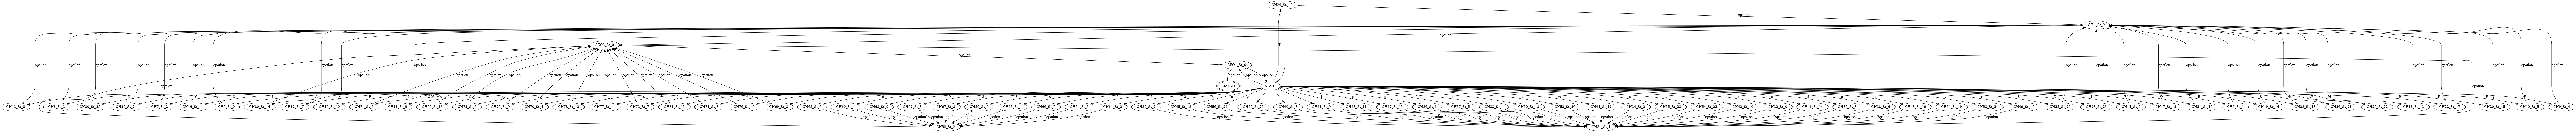

In [1094]:
enfa.plot_dot()

In [1095]:
enfa.validate_sequence(["0","_"])

{' ',
 '$',
 "'",
 '(',
 ')',
 '*',
 ',',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '<REDUCE>',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '}'}

In [659]:
_9

NameError: name '_9' is not defined